In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
%matplotlib inline

In [2]:
plt.style.use("seaborn-talk")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
df = pd.read_csv("D:/Imarticus/Paper1/MonthWiseMarketArrivals_clean.csv")
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [4]:
df.shape

(10227, 10)

In [5]:
df.dtypes

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object

In [6]:
df.index = pd.PeriodIndex(df.date, freq="M")
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2005-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
2006-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2010-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
2011-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
2012-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [7]:
df = df.drop(columns = ["year", "state", ], axis  = 1)

In [8]:
df_mumbai = df.loc[df.city == "MUMBAI"].copy()
df_mumbai.head()

,market,month,quantity,priceMin,priceMax,priceMod,city,date
date,,,,,,,,
2004-01,MUMBAI,January,267100,719,971,849,MUMBAI,January-2004
2005-01,MUMBAI,January,275845,261,513,387,MUMBAI,January-2005
2006-01,MUMBAI,January,228000,315,488,402,MUMBAI,January-2006
2007-01,MUMBAI,January,205200,866,1136,997,MUMBAI,January-2007
2008-01,MUMBAI,January,267550,348,550,448,MUMBAI,January-2008


In [9]:
df_mumbai.shape

(146, 8)

### Modal price of onion in Mumbai market for every month

In [10]:
df_mumbai_2 = df_mumbai.groupby("month").sum()
df_mumbai_2[["priceMod"]]

,priceMod
month,
April,7579
August,17129
December,15826
February,11245
January,14185
July,12578
June,10615
March,8092
May,8156


In [11]:
df_mumbai_2.head()

,quantity,priceMin,priceMax,priceMod
month,,,,
April,2819136,6252,8854,7579
August,2217877,14637,19395,17129
December,2942334,11576,19808,15826
February,2951595,8947,13405,11245
January,3445944,10645,17424,14185


<AxesSubplot:>

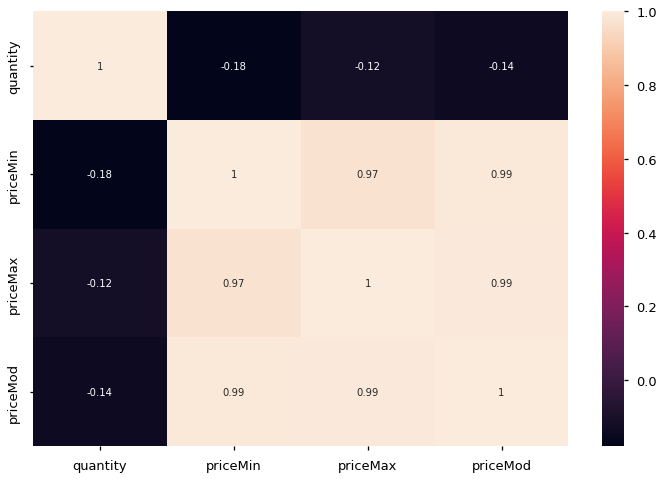

In [12]:
sns.heatmap(data = df_mumbai.corr(), annot = True)

In [13]:
df_mumbai = df_mumbai.drop(columns = ["quantity"], axis  = 1)

<AxesSubplot:ylabel='Frequency'>

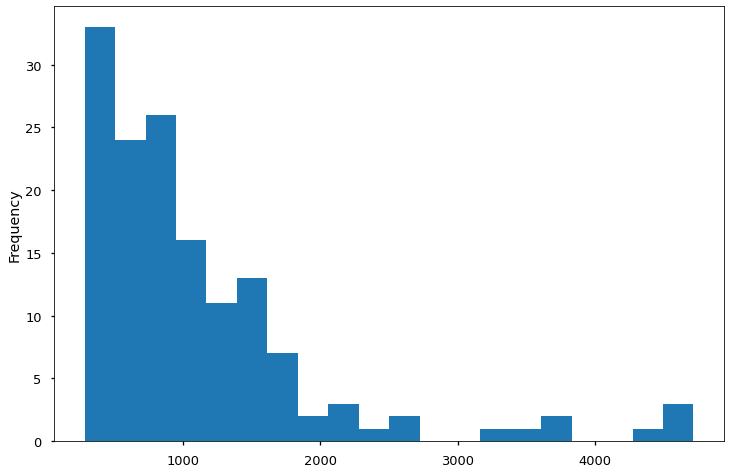

In [14]:
df_mumbai["priceMod"].plot(kind="hist", bins=20)

<AxesSubplot:ylabel='Frequency'>

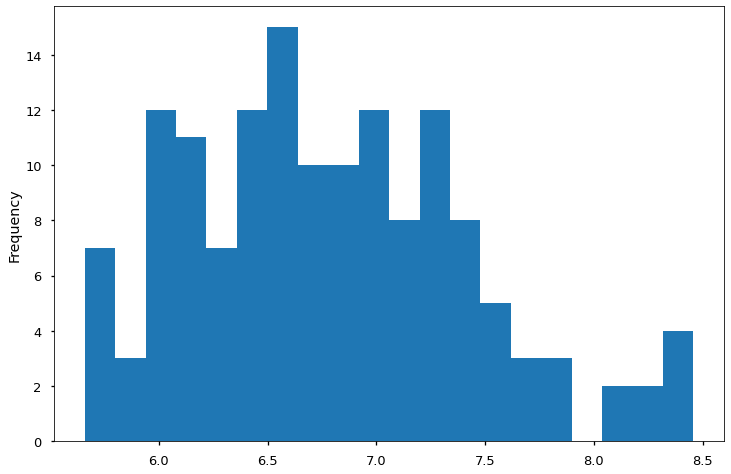

In [15]:
df_mumbai["log_priceMod"] = np.log(df_mumbai.priceMod)
df_mumbai.log_priceMod.plot(kind="hist", bins=20)

### Building Model

In [16]:
df_mumbai_mean = df_mumbai.log_priceMod.mean()
df_mumbai["mean_price"] = np.exp(df_mumbai_mean)
df_mumbai.head()

,market,month,priceMin,priceMax,priceMod,city,date,log_priceMod,mean_price
date,,,,,,,,,
2004-01,MUMBAI,January,719,971,849,MUMBAI,January-2004,6.744059,889.100239
2005-01,MUMBAI,January,261,513,387,MUMBAI,January-2005,5.958425,889.100239
2006-01,MUMBAI,January,315,488,402,MUMBAI,January-2006,5.996452,889.100239
2007-01,MUMBAI,January,866,1136,997,MUMBAI,January-2007,6.904751,889.100239
2008-01,MUMBAI,January,348,550,448,MUMBAI,January-2008,6.104793,889.100239


<AxesSubplot:xlabel='date'>

<Figure size 1440x2160 with 0 Axes>

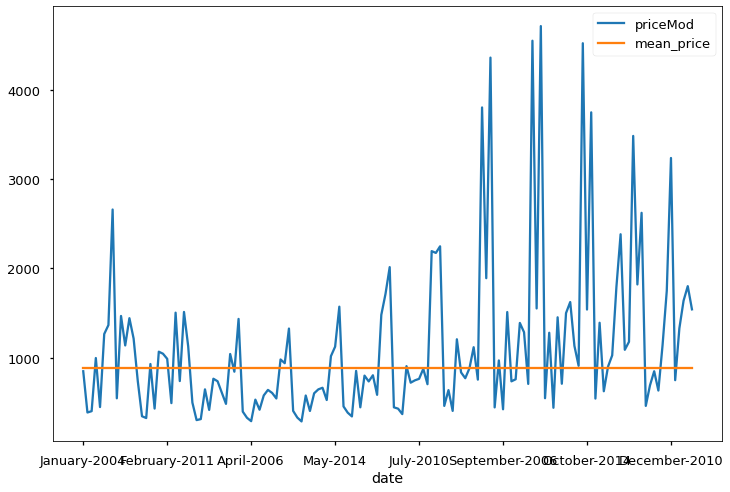

In [17]:
plt.figure(figsize = (20,30))
df_mumbai.plot(kind="line", x="date", y=["priceMod", "mean_price"])

### RMSE

In [18]:
def RMSE(actual, predicted):
    mse = (actual - predicted)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [19]:
modelRMSE = RMSE(df_mumbai.priceMod, df_mumbai.mean_price)
modelRMSE

908.4772843986449

### ACF and PACF plots

In [20]:
ts = df_mumbai.log_priceMod
# ts_diff = df_mumbai.log_priceMod_diff
# ts_diff.dropna(inplace = True)

In [21]:
lag_acf = acf(ts, nlags=20)
lag_acf

C:\Users\arjun\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        ,  0.31319668,  0.37165336, -0.06140673,  0.16869007,
       -0.02175521,  0.16634997,  0.01127215,  0.10597047, -0.07053858,
        0.27560045,  0.29894124,  0.78300906,  0.35419085,  0.29376392,
       -0.02414901,  0.1003445 ,  0.00663592,  0.1009527 ,  0.02262413,
        0.07107539])

<AxesSubplot:>

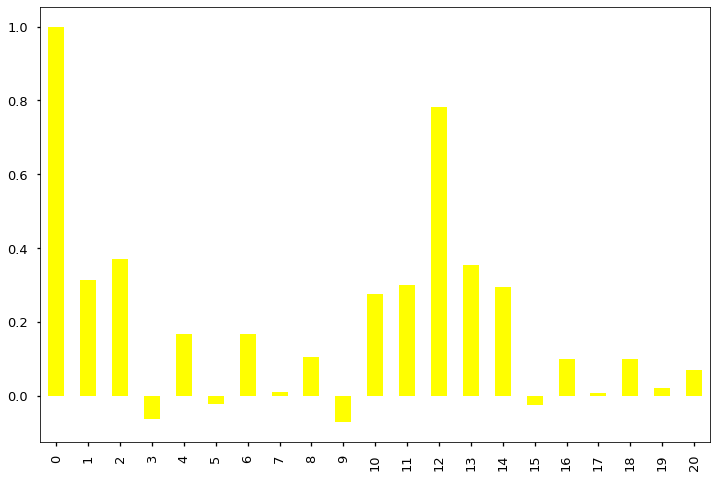

In [22]:
ACF = pd.Series(lag_acf)
ACF.plot(kind="bar", color="yellow")

<AxesSubplot:>

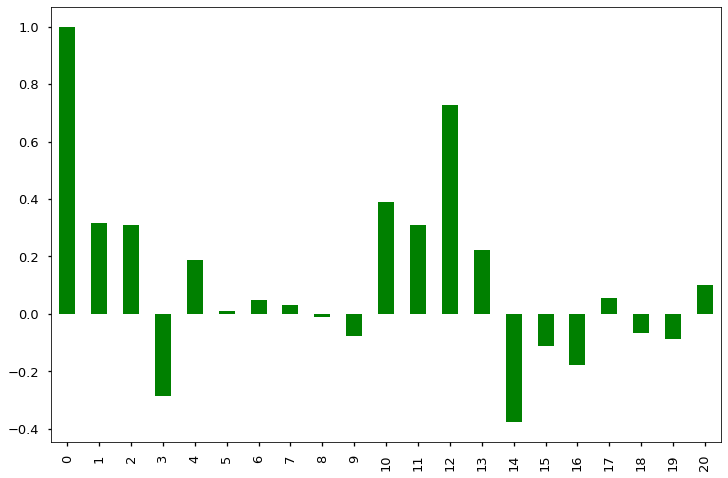

In [23]:
lag_pacf = pacf(ts, nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind="bar", color="green")